In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()
from ipywidgets import interactive, interact
import os
import pandas as pd
from skimage.measure import regionprops_table
import seaborn as sns
from tqdm.notebook import tqdm
from skimage.transform import resize
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
from joblib import delayed, Parallel

In [3]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
from natsort import natsorted

In [5]:
model = StarDist2D(None, name='stardist_no_shape_completion', basedir='/home/georgeos/Storage/Google Drive (Cambridge Univeristy)/SYMPTOMM_models/Ph2_data/bent_noisematched_allsize_empty_und6_unarelu_unlasigmoid_epc1000')


X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/extracted_long_trenches/*.tif"))
X = list(map(imread,X))

requires_resize = True
resize_shape = (256,64)
if requires_resize:
    #X = [resize(x,(32,8), order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None) for x in tqdm(X)]
    X = [resize(x,resize_shape, order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None) for x in tqdm(X)]

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))




Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


  0%|          | 0/30825 [00:00<?, ?it/s]

In [10]:
names = sorted(os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/extracted_long_trenches/"))

In [11]:
npnames = np.array(names)
a = 1
trenches_idx = {}
current_trench = "trench_{}".format(str(a).zfill(4))
while len((trench_idx := np.flatnonzero(np.core.defchararray.find(npnames,current_trench)!=-1))) > 0:
    trenches_idx[current_trench] = trench_idx
    a+=1
    current_trench = "trench_{}".format(str(a).zfill(4))

In [12]:
trench_names = list(trenches_idx.keys())
npX = np.array(X)

In [13]:
#it should be sufficient to just take the first peak for the trench height
@interact(z=(0,len(trenches_idx)-1))
def find_trench_top(z,plot=True):
    mean_y = npX[trenches_idx[trench_names[z]]].mean(axis=(0,2))
    mean_y_peak = find_peaks(mean_y,prominence = 10)[0]
    top_peak = mean_y_peak[np.where(mean_y_peak > 30)][0]
    if plot:
        plt.scatter(top_peak,mean_y[top_peak],c="r")
        plt.plot(mean_y)
        plt.show()
        plt.close()
    return top_peak

interactive(children=(IntSlider(value=616, description='z', max=1232), Checkbox(value=True, description='plot'…

In [14]:
trench_tops = {}
for z in range(len(trench_names)):
    trench_tops[trench_names[z]] = find_trench_top(z, plot=False)

In [15]:
#We gaussian blur in order to ensure 1 peak
@interact(z=(0,len(trenches_idx)-1))
def find_trench_sides(z,plot=True):
    mean_x = npX[trenches_idx[trench_names[z]]].mean(axis=(0,1))
    mean_x = gaussian_filter(mean_x,sigma=7)
    mean_x_peak = find_peaks(mean_x**6,prominence = 2)[0]
    if plot:
        plt.scatter(mean_x_peak,mean_x[mean_x_peak],c="r")
        plt.plot(mean_x)
        plt.show()
        plt.close()
    return mean_x_peak[0]+3

interactive(children=(IntSlider(value=616, description='z', max=1232), Checkbox(value=True, description='plot'…

In [16]:
trench_mids = {}
for z in range(len(trench_names)):
    trench_mids[trench_names[z]] = find_trench_sides(z, plot=False)

In [17]:
top_offset = 20
mid_offset = 22

@interact(z=(0,len(trenches_idx)-1))
def trench_cropper(z,plot=True, give_image = False):
    current_trench_name = trench_names[z]
    current_img = X[trenches_idx[current_trench_name][6]]
    if type(give_image) != type(False):
        current_img = give_image
    top_coord = trench_tops[current_trench_name]
    mid_coord = trench_mids[current_trench_name]
    cropped_img = current_img[top_coord-top_offset:,mid_coord-mid_offset:mid_coord+mid_offset]
    if plot:
        plt.imshow(cropped_img,cmap = "Greys_r")
        plt.show()
        plt.close()
    return cropped_img

interactive(children=(IntSlider(value=616, description='z', max=1232), Checkbox(value=True, description='plot'…

In [18]:
def clear_side_masks(labels, trench_n):
    masks_removed = clear_border(trench_cropper(trench_n, plot=False, give_image=labels))
    new_labels = np.zeros(labels.shape)
    for c in np.unique(masks_removed):
        new_labels += np.where(labels != c,new_labels,c)
    new_labels = new_labels.astype(bool)*labels
    return new_labels

In [51]:
mask_dirs = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/predictions_0.2/masks_resized/*"))

a = 0
for trench in tqdm(trench_names):
    idxs = trenches_idx[trench]
    for z in (idxs):
        current_mask = imread(mask_dirs[z])
        cleared_mask = clear_side_masks(current_mask,a)
        imsave(output_dir+"/postprocessed/{}".format(names[z]),cleared_mask)
    a+=1

  0%|          | 0/1233 [00:00<?, ?it/s]

In [52]:
cleared_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [22]:
from skimage.segmentation import clear_border

In [23]:
output_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/predictions_0.2"
try:
    os.mkdir(output_dir)
except:
    pass
try:
    os.mkdir(output_dir+"/masks_resized/")
    os.mkdir(output_dir+"/images_resized/")
except:
    pass
try:
    os.mkdir(output_dir+"/diagnostics/")
except:
    pass
try:
    os.mkdir(output_dir+"/postprocessed/")
except:
    pass

In [25]:
all_labels = []
all_details = []
for z in tqdm(range(len(X))):
    img = normalize(X[z], 1,100, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.2, nms_thresh=0.01)
    imsave(
        output_dir+"/masks_resized/{}".format(names[z]),labels)
    imsave(
        output_dir+"/images_resized/{}".format(names[z]),img)
    all_labels.append(labels)
    all_details.append(details)

  0%|          | 0/30825 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [26]:
a = 0
for trench in tqdm(trench_names):
    idxs = trenches_idx[trench]
    for z in (idxs):
        cleared_mask = clear_side_masks(all_labels[z],a)
        imsave(output_dir+"/postprocessed/{}".format(names[z]),cleared_mask)
    a+=1

  0%|          | 0/1233 [00:00<?, ?it/s]

IndexError: list index out of range

In [27]:
pp = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/predictions_0.2/postprocessed/*"))
lbls = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/predictions_0.2/postprocessed/*"))


def plotter(z): 
    labels = all_labels[z]
    details = all_details[z]
    img = X[z]
    probmap = np.zeros(labels.shape)
    for x in range(len(details["points"])):
        probmap[np.where(labels == labels[details["points"][x][0],details["points"][x][1]])] = details["prob"][x]
    f, ax = plt.subplots(1,5,figsize=(7.9,4))
    ax[0].imshow(img,cmap="Greys_r")
    ax[1].imshow(labels,cmap=lbl_cmap)
    prob = ax[3].imshow(probmap,cmap="afmhot",vmin=0,vmax=1)
    ax[2].imshow(img,cmap="Greys_r")
    ax[2].imshow(labels,cmap=lbl_cmap,alpha=0.45)
    ax[2].set_title("PC+Masks")
    f.colorbar(prob,ax=ax[3])
    ax[3].set_title("P(Mask)")
    ax[1].set_title("Masks")
    ax[0].set_title("PC_image")
    ax[4].imshow(imread(pp[z]),cmap=lbl_cmap)
    ax[4].set_title("Post-proc")
    for axs in ax:
        axs.axis("off")
    plt.tight_layout()
    plt.savefig(output_dir+"/diagnostics/{}".format(names[z][:-3]+"jpeg"),dpi=100)
    plt.close()

In [28]:
Parallel(n_jobs=1)(delayed(plotter)(i) for i in tqdm(range(len(all_labels)))) #plotter is leaking memory, use n_jobs = 1 for now

  0%|          | 0/15 [00:00<?, ?it/s]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [29]:
output_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/predictions_0.1"
try:
    os.mkdir(output_dir)
except:
    pass
try:
    os.mkdir(output_dir+"/masks_resized/")
    os.mkdir(output_dir+"/images_resized/")
except:
    pass
try:
    os.mkdir(output_dir+"/diagnostics/")
except:
    pass
try:
    os.mkdir(output_dir+"/postprocessed/")
except:
    pass

In [30]:
all_labels = []
all_details = []
for z in tqdm(range(len(X))):
    img = normalize(X[z], 1,100, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.1, nms_thresh=0.01)
    imsave(
        output_dir+"/masks_resized/{}".format(names[z]),labels)
    imsave(
        output_dir+"/images_resized/{}".format(names[z]),img)
    all_labels.append(labels)
    all_details.append(details)

  0%|          | 0/30825 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [31]:
a = 0
for trench in tqdm(trench_names):
    idxs = trenches_idx[trench]
    for z in (idxs):
        cleared_mask = clear_side_masks(all_labels[z],a)
        imsave(output_dir+"/postprocessed/{}".format(names[z]),cleared_mask)
    a+=1

  0%|          | 0/1233 [00:00<?, ?it/s]

IndexError: list index out of range

In [32]:
pp = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/predictions_0.1/postprocessed/*"))

def plotter(z): 
    labels = all_labels[z]
    details = all_details[z]
    img = X[z]
    probmap = np.zeros(labels.shape)
    for x in range(len(details["points"])):
        probmap[np.where(labels == labels[details["points"][x][0],details["points"][x][1]])] = details["prob"][x]
    f, ax = plt.subplots(1,5,figsize=(7.9,4))
    ax[0].imshow(img,cmap="Greys_r")
    ax[1].imshow(labels,cmap=lbl_cmap)
    prob = ax[3].imshow(probmap,cmap="afmhot",vmin=0,vmax=1)
    ax[2].imshow(img,cmap="Greys_r")
    ax[2].imshow(labels,cmap=lbl_cmap,alpha=0.45)
    ax[2].set_title("PC+Masks")
    f.colorbar(prob,ax=ax[3])
    ax[3].set_title("P(Mask)")
    ax[1].set_title("Masks")
    ax[0].set_title("PC_image")
    ax[4].imshow(imread(pp[z]),cmap=lbl_cmap)
    ax[4].set_title("Post-proc")
    for axs in ax:
        axs.axis("off")
    plt.tight_layout()
    plt.savefig(output_dir+"/diagnostics/{}".format(names[z][:-3]+"jpeg"),dpi=100)
    plt.close()

  0%|          | 0/30825 [00:00<?, ?it/s]

KeyboardInterrupt: 

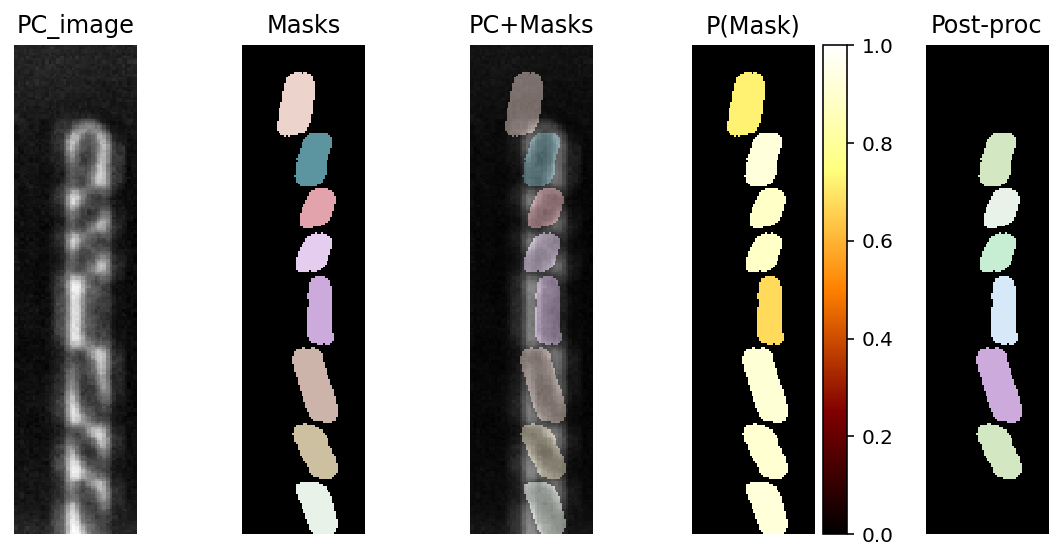

In [21]:
Parallel(n_jobs=1)(delayed(plotter)(i) for i in tqdm(range(len(all_labels)))) #plotter is leaking memory, use n_jobs = 1 for now

## playing around

In [34]:
len(X)

30825

In [37]:
model = StarDist2D(None, name='stardist_no_shape_completion', basedir='/home/georgeos/Storage/Google Drive (Cambridge Univeristy)/SYMPTOMM_models/Ph2_data/bent_noisematched_allsize_empty_und6_unarelu_unlasigmoid_epc1000')


X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/extracted_long_trenches/*.tif"))[:500]
X = list(map(imread,X))

requires_resize = True
resize_shape = (256,64)
if requires_resize:
    #X = [resize(x,(32,8), order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None) for x in tqdm(X)]
    X = [resize(x,resize_shape, order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None) for x in tqdm(X)]

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))




all_labels_1 = []
all_details_1 = []
all_imgs_1 = []
for z in range(len(X[:500])):
    img = normalize(X[z], 1,100, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.7, nms_thresh=0.1)
    all_labels_1.append(labels)
    all_details_1.append(details)
    all_imgs_1.append(img)

@interact
def plotter_1(x=(0,len(X[:500])-1)):
    plt.figure(figsize=(8,8))
    plt.imshow(all_imgs_1[x] if all_imgs_1[x].ndim==2 else all_imgs_1[x][...,0], clim=(0,1), cmap='gray')
    plt.imshow(all_labels_1[x], cmap=lbl_cmap, alpha=0.35)
    plt.axis('off');
    plt.show()
    plt.close()

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


  0%|          | 0/500 [00:00<?, ?it/s]

interactive(children=(IntSlider(value=249, description='x', max=499), Output()), _dom_classes=('widget-interac…

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(resize(all_imgs_1[0],(211,40), order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None),cmap="Greys_r")

In [ ]:
from scipy.signal import find_peaks
from skimage.segmentation import clear_border

In [ ]:
properties = ["area","centroid","major_axis_length","minor_axis_length"]

trenches = os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/")
trenches.sort()
model = StarDist2D(None, name='stardist_no_shape_completion', basedir='models_mixed_size_1600_epoch_good_50')
all_cell_data = pd.DataFrame()
master_label = []
master_imgs = []
exception_trenches = ["trench_52", "trench_54"]
for trench in tqdm(trenches):
    cell_data = pd.DataFrame()

    X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/{}/*.tif".format(trench)))
    X = list(map(imread,X))

    n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
    axis_norm = (0,1)   # normalize channels independently
    # axis_norm = (0,1,2) # normalize channels jointly
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))


    all_labels = []
    all_details = []
    all_imgs = []
    for z in range(3,25):
        img = normalize(X[z], 1,100, axis=axis_norm)
        if z == 3:
            if trench in exception_trenches:
                midpoint = int(img.shape[1]/2)
            else:
                image_profile = img.mean(axis=0)
                peaks = find_peaks(image_profile, height=np.mean(image_profile)*0.9)
                if len(peaks[0]) > 1:
                    midpoint = int(np.sum(peaks[0])/2)
                elif len(peaks[0]) == 1:
                    midpoint = peaks[0][0]
                trench_half_width = 15
        
        labels, details = model.predict_instances(img, prob_thresh=0.7, nms_thresh=0.1)
        

        labels = clear_border(labels[:,midpoint-trench_half_width:midpoint+trench_half_width])
        
        
        all_labels.append(labels)
        all_details.append(details)
        all_imgs.append(img[:,midpoint-trench_half_width:midpoint+trench_half_width])
        
    for label_image in all_labels:
        if len(np.unique(label_image)) > 1:
            cell_data = cell_data.append(pd.DataFrame(regionprops_table(label_image=label_image, properties=properties)).sort_values(by = "centroid-0").iloc[0])
        else:
            cell_data = cell_data.append(pd.Series([np.nan]*len(properties)),ignore_index=True)
    cell_data.reset_index(inplace=True,drop=True)
    cell_data["cell"] = trench
    cell_data["time"] = range(3,25)
    all_cell_data = all_cell_data.append(cell_data)
    all_cell_data.reset_index(inplace=True,drop=True)
    master_label.append(all_labels)
    master_imgs.append(all_imgs)

In [ ]:
g = sns.FacetGrid(all_cell_data, col='cell', col_wrap=7)
g = g.map(sns.lineplot, 'time', 'major_axis_length', ci=None).add_legend()
plt.tight_layout()
plt.savefig("test_1600_epoch_50perc.pdf")

In [ ]:
for x in range(len(master_imgs[0])):
    plt.imshow(master_imgs[54][x],cmap="Greys_r")
    plt.imshow(master_label[54][x],alpha=0.4,cmap="jet")
    plt.show()
    plt.close()

In [ ]:
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

In [ ]:
all_labels = []
all_details = []
all_imgs = []
for z in range(25):
    img = normalize(X[z], 1,100, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.6, nms_thresh=0.1)
    all_labels.append(labels)
    all_details.append(details)
    all_imgs.append(img)
    
@interact
def plotter(x=(0,len(X)-1)):
    plt.figure(figsize=(8,8))
    plt.imshow(all_imgs[x] if all_imgs[x].ndim==2 else all_imgs[x][...,0], clim=(0,1), cmap='gray')
    plt.imshow(all_labels[x], cmap=lbl_cmap, alpha=0.35)
    plt.axis('off');
    plt.show()
    plt.close()

In [ ]:
from skimage.measure import regionprops, regionprops_table
import pandas as pd

In [ ]:
trenches = os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/")

In [ ]:
a = 0
for t in range(len(trench))
cell_data = pd.DataFrame()
for label_image in all_labels:
    cell_data = cell_data.append(pd.DataFrame(regionprops_table(label_image=label_image, properties=properties)).sort_values(by = "centroid-0").iloc[0])
cell_data.reset_index(inplace=True,drop=True)
cell_data["cell"] = a

In [ ]:
cell_data

In [20]:
model = StarDist2D(None, name='stardist_no_shape_completion', basedir='models_nohist')

trenches = os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/")
all_cell_data = pd.DataFrame()
for trench in trenches:
    cell_data = pd.DataFrame()

    X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/{}/*.tif".format(trench)))
    X = list(map(imread,X))

    n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
    axis_norm = (0,1)   # normalize channels independently
    # axis_norm = (0,1,2) # normalize channels jointly
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))


    all_labels = []
    all_details = []
    all_imgs = []
    for z in range(0,25):
        img = normalize(X[z], 1,100, axis=axis_norm)
        labels, details = model.predict_instances(img, prob_thresh=0.7, nms_thresh=0.1)
        all_labels.append(labels)
        all_details.append(details)
        all_imgs.append(img)
        
    for label_image in all_labels:
        cell_data = cell_data.append(pd.DataFrame(regionprops_table(label_image=label_image, properties=properties)).sort_values(by = "centroid-0").iloc[0])
    cell_data.reset_index(inplace=True,drop=True)
    cell_data["cell"] = trench
    cell_data["time"] = range(0,25)
    all_cell_data = all_cell_data.append(cell_data)
    all_cell_data.reset_index(inplace=True,drop=True)
    print(trench)


FileNotFoundError: config file doesn't exist: /home/georgeos/Documents/GitHub/SYMPTOMM2/examples/deep_learning/StarDist/models_nohist/stardist_no_shape_completion/config.json

In [ ]:
all_cell_data["minor_axis_length"] = (all_cell_data["minor_axis_length"])*2.5

In [ ]:
all_cell_data_temp = pd.melt(all_cell_data,value_vars=["major_axis_length","minor_axis_length"],id_vars =["centroid-0","centroid-1","cell","time"])

In [ ]:
g = sns.FacetGrid(all_cell_data_temp, col='cell', hue="variable",col_wrap=7)
g = g.map(sns.lineplot, 'time', "value", ci=None).add_legend()
plt.tight_layout()
plt.savefig("test_nohist.pdf",dpi=200)

In [ ]:
model = StarDist2D(None, name='stardist_no_shape_completion', basedir='models')

trenches = os.listdir("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/")
all_cell_data = pd.DataFrame()
for trench in trenches:
    cell_data = pd.DataFrame()

    X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/{}/*.tif".format(trench)))
    X = list(map(imread,X))

    n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
    axis_norm = (0,1)   # normalize channels independently
    # axis_norm = (0,1,2) # normalize channels jointly
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))


    all_labels = []
    all_details = []
    all_imgs = []
    for z in range(0,25):
        img = normalize(X[z], 1,100, axis=axis_norm)
        labels, details = model.predict_instances(img, prob_thresh=0.65, nms_thresh=0.1)
        all_labels.append(labels)
        all_details.append(details)
        all_imgs.append(img)
        
    for label_image in all_labels:
        cell_data = cell_data.append(pd.DataFrame(regionprops_table(label_image=label_image, properties=properties)).sort_values(by = "centroid-0").iloc[0])
    cell_data.reset_index(inplace=True,drop=True)
    cell_data["cell"] = trench
    cell_data["time"] = range(0,25)
    all_cell_data = all_cell_data.append(cell_data)
    all_cell_data.reset_index(inplace=True,drop=True)
    print(trench)
g = sns.FacetGrid(all_cell_data, col='cell', col_wrap=7)
g = g.map(sns.lineplot, 'time', 'major_axis_length', ci=None).add_legend()
plt.tight_layout()
plt.savefig("test_mixed_cells.png",dpi=200)

In [ ]:
all_labels_1 = []
all_details_1 = []
all_imgs_1 = []
for z in range(25):
    img = normalize(X[z], 1,100, axis=axis_norm)
    labels, details = model.predict_instances(img, prob_thresh=0.6, nms_thresh=0.1)
    all_labels_1.append(labels)
    all_details_1.append(details)
    all_imgs_1.append(img)
    
@interact
def plotter_1(x=(0,len(X)-1)):
    plt.figure(figsize=(8,8))
    plt.imshow(all_imgs_1[x] if all_imgs[x].ndim==2 else all_imgs_1[x][...,0], clim=(0,1), cmap='gray')
    plt.imshow(all_labels_1[x], cmap=lbl_cmap, alpha=0.35)
    plt.axis('off');
    plt.show()
    plt.close()